# Human Written Text vs. AI Generated Text
### INF582
Hugo BOUIGEON, Thomas LI, Jules POTEL





---

# Home Made Roberta

---

## Imports

In [ ]:
!pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.0/769.0 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.2 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=33b41d2158726a14ad9cdff7d456e2480d08e52b5ae141e02dcc62c62024cb64
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Root Path

In [ ]:
# Modify
ROOT_PATH = "/content/drive/My Drive/Polytechnique/INF582/"

In [ ]:
!ls "/content/drive/My Drive/Polytechnique/INF582"

 IN582_2023_Challenge.pdf	   submission.csv
 INF582_final_project.ipynb	  'submission_random forest.csv'
 INF582_homemade.ipynb		   submission_random_forest_len.csv
 INF582_roberta.ipynb		   test_set.json
 logistic_regression_baseline.py   train_set.json
 submission_all_zeros.csv


In [ ]:
# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
import json
import csv

from tqdm.notebook import tqdm, tnrange

from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("device =", device)

device = cuda


In [ ]:
# Read The data
training_set = pd.read_json(ROOT_PATH + 'train_set.json')
test_set = pd.read_json(ROOT_PATH + 'test_set.json')
test_set['label'] = 0 #these are fake labels, it is just easier this way to tokenize it

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_set, test_size=0.2, shuffle=True, stratify=training_set['label'])

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)

## Config

In [ ]:
CONFIG = {
    'MAX_LEN' : 256,
    'TRAIN_BATCH_SIZE' : 8,
    'VALID_BATCH_SIZE' : 4,
    'LEARNING_RATE' : 1e-05,
    'MODEL_NAME' : 'roberta-base',
}

MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05

## Dataset

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
class My_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text #column name
        self.targets = dataframe.label #column name
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = My_Dataset(train_set, tokenizer, MAX_LEN)
val_dataset = My_Dataset(val_set, tokenizer, MAX_LEN)
test_dataset = My_Dataset(test_set, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

val_params = test_params

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

## Model

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

## Training functions

In [ ]:
from IPython.display import display

def end_display(loss_train, loss_val, accuracy_train, accuracy_val):
    n_epoch = len(loss_train)
    x = [i for i in range(1, n_epoch+1)]
    plt.figure(figsize = (8,6))
    plt.subplot(2, 1, 1) #lignes, colonnes, position (sens de la lecture)
    plt.plot(x, accuracy_train, label="Training Accuracy", c='blue', ls='--', lw=1)
    plt.plot(x, accuracy_val, label="Validiation Accuracy", c='red', ls='--', lw=1)
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_train, label="Training Loss", c='blue', ls='--', lw=1)
    plt.plot(x, loss_val, label="Validation Loss", c='red', ls='--', lw=1)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    epochs = [i for i in range(1, n_epoch+1)]
    data_array = np.array([epochs ,loss_train, loss_val, accuracy_train, accuracy_val]).T
    df = pd.DataFrame(data_array , columns = ['epochs', 'training_loss', 'validation_loss', 'training_accuracy', 'validation_accuracy'])
    display(df)
    

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr=LEARNING_RATE)

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def train(model, n_epoch = 1, NAME = 'last_model'):
    """
    To use this function you must have defined :
      - train_loader
      - val_loader
      - loss_function
      - optimizer
      - calcuate_accuracy

    """
    loss_train = []
    loss_val = []
    accuracy_train = []
    accuracy_val = []
    record_accuracy = 0
    PATH = ROOT_PATH + NAME + ".pth"
    print(f"PATH = {PATH}")

    for epoch in tqdm(range(n_epoch), desc='Epoch'):
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        n_train_examples = 0
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        n_val_examples = 0
        for data in tqdm(train_loader, desc='Processing epoch', leave=False):
            # unpack data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            # compute output and loss
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            epoch_train_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1) # argmax
            epoch_train_accuracy += calcuate_accuracy(big_idx, targets) # define calcuate_accuracy function
            n_train_examples+=targets.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # at the end of the epoch, compute validation loss and accuracy
        with torch.no_grad(): 
            for data in tqdm(val_loader, desc='Epoch validation accuracy', leave=False):
                # unpack data
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                # compute prediction and loss
                outputs = model(ids, mask, token_type_ids)
                loss = loss_function(outputs, targets)
                epoch_val_loss += loss.item()
                big_val, big_idx = torch.max(outputs.data, dim=1) # argmax
                epoch_val_accuracy += calcuate_accuracy(big_idx, targets) # define calcuate_accuracy function
                n_val_examples+=targets.size(0)

        # Save the accuracies and the losses
        epoch_train_loss = epoch_train_loss / n_train_examples
        epoch_val_loss = epoch_val_loss / n_val_examples
        epoch_train_accuracy = epoch_train_accuracy / n_train_examples
        epoch_val_accuracy = epoch_val_accuracy / n_val_examples
        loss_train.append(epoch_train_loss)
        loss_val.append(epoch_val_loss)
        accuracy_train.append(epoch_train_accuracy)
        accuracy_val.append(epoch_val_accuracy)

        # Display stats at the end of each epoch

        end_display(loss_train, loss_val, accuracy_train, accuracy_val)

        if epoch_val_accuracy > record_accuracy:
            torch.save(model.state_dict(), PATH)
            print(f'Saved model under {PATH}')
            record_accuracy = epoch_val_accuracy

    # Load best model at the end
    print("Finished Training")
    model = RobertaClass()
    model.to(device)
    model.load_state_dict(torch.load(PATH))
    print("Best model reloaded sucessfully")
    


## Training Runs

PATH = /content/drive/My Drive/Polytechnique/INF582/last_model.pth


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch validation accuracy:   0%|          | 0/100 [00:00<?, ?it/s]

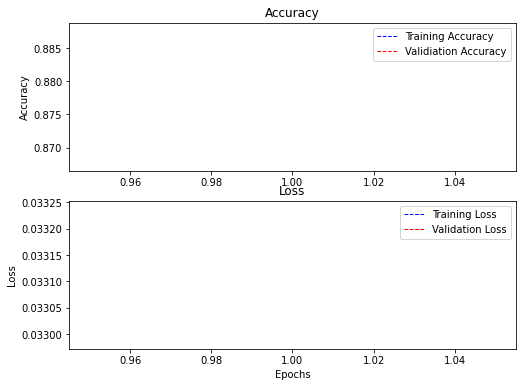

,epochs,training_loss,validation_loss,training_accuracy,validation_accuracy
0,1.0,0.032985,0.03324,0.887813,0.8675


Epoch 1: train_accuracy = 0.8878125, train_loss = 0.03298540711970418, val_accuracy = 0.8675, val_loss = 0.03324040985316969
Saved model under /content/drive/My Drive/Polytechnique/INF582/last_model.pth


Processing epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch validation accuracy:   0%|          | 0/100 [00:00<?, ?it/s]

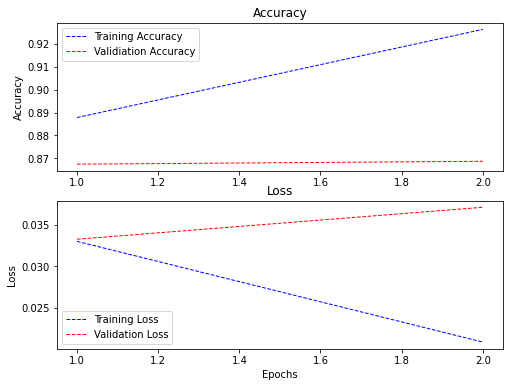

,epochs,training_loss,validation_loss,training_accuracy,validation_accuracy
0,1.0,0.032985,0.033240,0.887813,0.86750
1,2.0,0.020890,0.037075,0.926250,0.86875


Epoch 2: train_accuracy = 0.92625, train_loss = 0.020889747028704733, val_accuracy = 0.86875, val_loss = 0.037074609707342464
Saved model under /content/drive/My Drive/Polytechnique/INF582/last_model.pth


Processing epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch validation accuracy:   0%|          | 0/100 [00:00<?, ?it/s]

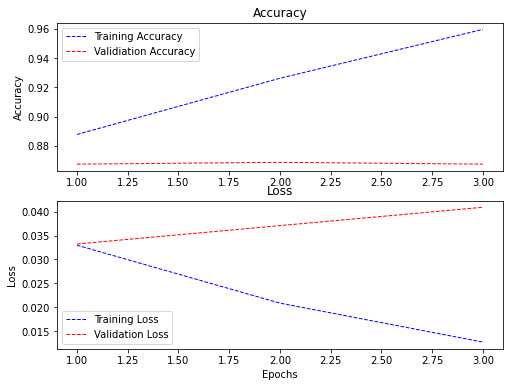

,epochs,training_loss,validation_loss,training_accuracy,validation_accuracy
0,1.0,0.032985,0.033240,0.887813,0.86750
1,2.0,0.020890,0.037075,0.926250,0.86875
2,3.0,0.012755,0.040903,0.959688,0.86750


Epoch 3: train_accuracy = 0.9596875, train_loss = 0.012754510585655226, val_accuracy = 0.8675, val_loss = 0.04090299362011138
Finished Training
FBest model reloaded sucessfully


In [ ]:
train(model, n_epoch = 3, NAME = 'roberta')

## Sandbox

In [ ]:
data = next(iter(test_loader))

In [ ]:
ids = data['ids'].to(device, dtype = torch.long)
mask = data['mask'].to(device, dtype = torch.long)
token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
targets = data['targets'].to(device, dtype = torch.long)

# compute prediction and loss
outputs = model(ids, mask, token_type_ids)

In [ ]:
data

{'ids': tensor([[    0,   417, 23656,  ...,     1,     1,     1],
         [    0,   417, 23656,  ...,     1,     1,     1],
         [    0,  3209,  3019,  ...,     1,     1,     1],
         [    0, 31828,  3809,  ...,     1,     1,     1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([0., 0., 0., 0.])}

In [ ]:
outputs

tensor([[ 3.4120, -3.6542],
        [-3.6244,  3.1589],
        [-1.0202,  1.1611],
        [-1.3860,  1.1801]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Submission

In [ ]:
def submit(my_pred, name = 'last_submission'):
  # Write predictions to a file
  with open(name + ".csv", "w") as pred:
      csv_out = csv.writer(pred)
      csv_out.writerow(['id','label'])
      for i, row in enumerate(my_pred):
          csv_out.writerow([i, row])

def predict(model, name = 'last_submission'):
    my_pred = []
    with torch.no_grad(): 
        for data in tqdm(test_loader, desc='Predicting', leave=False):
            # unpack data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            n_batch = len(ids)

            # compute output and loss
            outputs = model(ids, mask, token_type_ids)
            big_val, big_idx = torch.max(outputs.data, dim=1) # argmax
            my_pred += list(big_idx.cpu().numpy())

    # Save submission
    submit(my_pred, name=name)
    print("submission saved at " + name + ".csv")

In [ ]:
predict(model, name = 'roberta_5epoch_submission')

Predicting:   0%|          | 0/1000 [00:00<?, ?it/s]

submission saved at name.csv


<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [ ]:
# output_model_file = 'pytorch_roberta_sentiment.bin'
# output_vocab_file = './'

# model_to_save = model
# torch.save(model_to_save, output_model_file)
# tokenizer.save_vocabulary(output_vocab_file)

# print('All files saved')
# print('This tutorial is completed')

All files saved
This tutorial is completed
